In [48]:
%matplotlib inline
import nba_py as nba
from nba_py import player
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import math

In [2]:
df = pd.read_csv('all_players.csv')

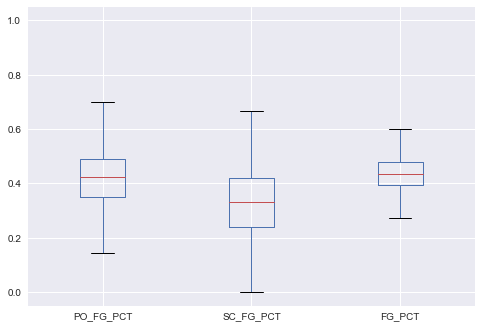

In [3]:
df.boxplot(['PO_FG_PCT','SC_FG_PCT','FG_PCT'])

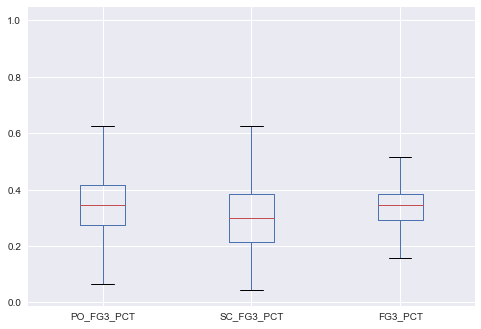

In [12]:
cur_df = df[df['FG3_PCT'] != 0]
cur_df = cur_df[cur_df['SC_FG3_PCT'] != 0]
cur_df[cur_df['PO_FG3_PCT'] != 0].boxplot(['PO_FG3_PCT','SC_FG3_PCT','FG3_PCT'])

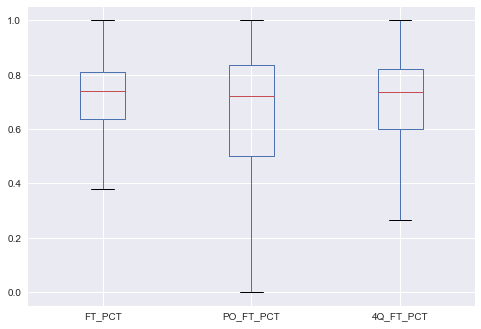

In [10]:
df.boxplot(['FT_PCT','PO_FT_PCT','4Q_FT_PCT'])

In [4]:
df['SC_FG_PCT_DIFF'] = df['FG_PCT'] - df['SC_FG_PCT']
df['SC_FG3_PCT_DIFF'] = df['FG3_PCT'] - df['SC_FG3_PCT']
df['PO_FT_PCT_DIFF'] = df['FT_PCT'] - df['PO_FT_PCT']
df['4Q_FT_PCT_DIFF'] = df['FT_PCT'] - df['4Q_FT_PCT']
df['SEASON_ID'] = df['GROUP_VALUE']

In [26]:
df2 = df[['SEASON_ID', 'PERSON_ID', 'SC_FG_PCT_DIFF', 'SC_FG3_PCT_DIFF',
       'PO_FT_PCT_DIFF', '4Q_FT_PCT_DIFF','FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK']]

In [27]:
def get_reg_season_totals(p_id):
    rt_df1 = player.PlayerCareer(p_id, per_mode = 'PerGame').regular_season_totals()[['PLAYER_ID','SEASON_ID',
                                                                          'PLAYER_AGE','MIN']]
    if rt_df1.empty:
        return None
    else:
        rt_df1 = rt_df1.groupby(['PLAYER_ID','SEASON_ID']).mean()
        rt_df1 = rt_df1.reset_index()
        rt_df2 = player.PlayerCareer(p_id, per_mode = 'PerGame').regular_season_totals()[['PLAYER_ID','SEASON_ID',
                                                                              'GP','GS','TEAM_ID']]
        rt_df2 = rt_df2[rt_df2['TEAM_ID'] != 0]
        rt_df2 = rt_df2[['PLAYER_ID','SEASON_ID','GP','GS']]
        rt_df2 = rt_df2.groupby(['PLAYER_ID','SEASON_ID']).sum()
        rt_df2 = rt_df2.reset_index()

        rt_df = pd.merge(rt_df1, rt_df2, how = 'left', on = ['PLAYER_ID','SEASON_ID'])
        return (rt_df)

In [28]:
plist = player.PlayerList(league_id='00', only_current = '0')
player_ids = plist.info()['PERSON_ID']
main_df = pd.DataFrame()
for cur_player in tqdm.tqdm(player_ids.values):
    cur_df = get_reg_season_totals(cur_player)
    if cur_df is not None:
        main_df = main_df.append(cur_df)

100%|██████████| 4232/4232 [1:11:51<00:00,  1.05it/s]


In [34]:
main_df.columns = ['GP','GS','AVG_MIN','AGE','PERSON_ID','SEASON_ID']
comb_df = pd.merge(df2,main_df, how = 'left', on = ['PERSON_ID','SEASON_ID'])


In [35]:
comb_df.to_csv('july18_data.csv')

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

TRY ANOTHER MODEL YEEEHHYYY!

In [46]:
total_df = comb_df[['SEASON_ID', 'PERSON_ID', 'FG_PCT',
       'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'AGE', 'GP', 'GS', 'AVG_MIN','SC_FG_PCT_DIFF']]
total_df = total_df.dropna()

In [49]:
target = total_df['SC_FG_PCT_DIFF']

features = total_df[['PERSON_ID', 'FG_PCT',
       'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'AGE', 'GP', 'GS', 'AVG_MIN']]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=4)

In [50]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
estimator.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [51]:
df_results = pd.DataFrame()
df_results['prediction'] = estimator.predict(X_test)
df_results['actual'] = y_test.values

In [63]:
def to_category_1(x):
    if x <= 0:
        return (1)
    else:
        return (0)

def to_category_2(x):
    if x <= 0.1:
        return (1)
    else:
        return (0)

In [64]:
df_results['abs_error'] = abs(df_results['actual'] - df_results['prediction'])
df_results['pct_error'] = df_results['abs_error']/df_results['actual']
df_results['prediction_cat'] = df_results['prediction'].apply(to_category_2)
df_results['actual_cat'] = df_results['actual'].apply(to_category_1)
df_results['cat_error'] = abs(df_results['actual_cat'] - df_results['prediction_cat'])
df_results['non_abs_cat_error'] = df_results['actual_cat'] - df_results['prediction_cat']

In [65]:
print('abs cat error: ' + str(df_results['cat_error'].mean()))
print('non abs cat error: ' + str(df_results['non_abs_cat_error'].mean()))
print('number of actual clutch correct: ' + str(df_results[df_results['actual_cat'] == 1]['cat_error'].mean()))
print('number of chokers correct: ' + str(df_results[df_results['actual_cat'] == 0]['cat_error'].mean()))
print('number of actual clutch: ' + str(df_results['actual_cat'].sum()))
print('number of predicted clutch: ' + str(df_results['prediction_cat'].sum()))

abs cat error: 0.47216494845360824
non abs cat error: -0.27835051546391754
number of actual clutch correct: 0.4845360824742268
number of chokers correct: 0.4690721649484536
number of actual clutch: 97
number of predicted clutch: 232


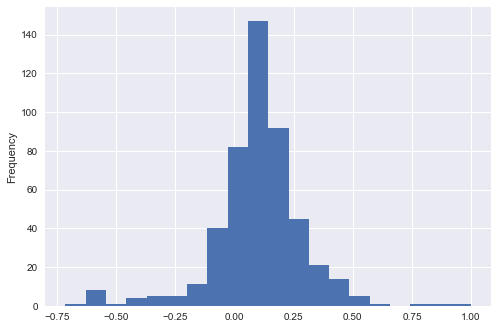

In [61]:
df_results['actual'].plot(kind = 'hist', bins = 20)

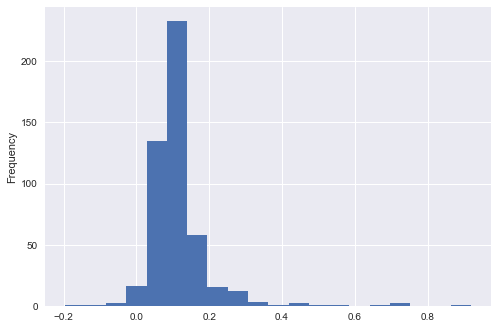

In [62]:
df_results['prediction'].plot(kind = 'hist', bins = 20)

JULY 18

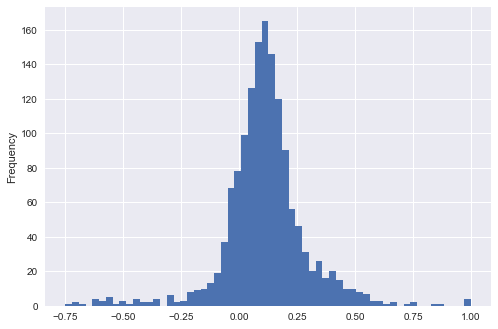

In [14]:
df['SC_FG_PCT_DIFF'].plot(kind = 'hist', bins = 60)

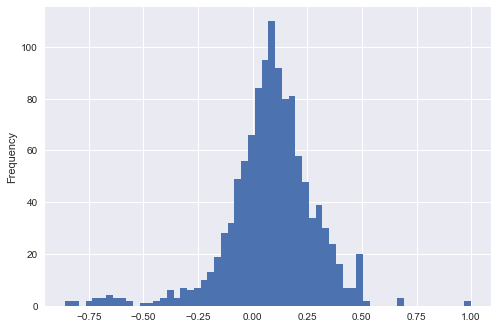

In [16]:
df[df['SC_FG3_PCT_DIFF'] != 0]['SC_FG3_PCT_DIFF'].plot(kind = 'hist', bins = 60)

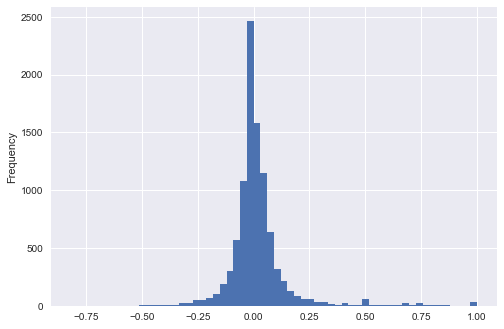

In [19]:
df['4Q_FT_PCT_DIFF'].plot(kind = 'hist', bins = 60)

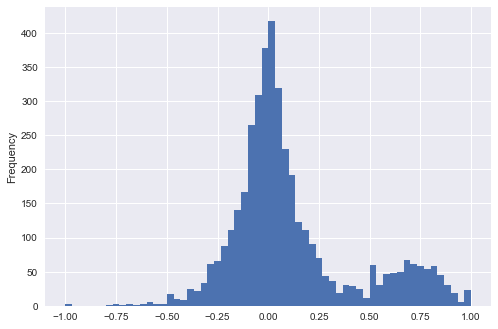

In [18]:
df['PO_FT_PCT_DIFF'].plot(kind = 'hist', bins = 60)

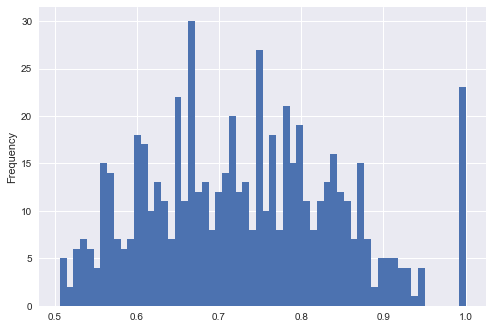

In [23]:
df[df['PO_FT_PCT_DIFF'] > 0.5]['PO_FT_PCT_DIFF'].plot(kind = 'hist', bins = 60)

In [25]:
df[df['PO_FT_PCT_DIFF'] > 0.5].columns

Index(['GROUP_VALUE', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB',
       'AST', 'TOV', 'STL', 'BLK', '4Q_FG_PCT', '4Q_FG3_PCT', '4Q_FT_PCT',
       '4Q_OREB', '4Q_DREB', '4Q_REB', '4Q_AST', '4Q_TOV', '4Q_STL', '4Q_BLK',
       'PO_FG_PCT', 'PO_FG3_PCT', 'PO_FT_PCT', 'PO_OREB', 'PO_DREB', 'PO_REB',
       'PO_AST', 'PO_TOV', 'PO_STL', 'PO_BLK', 'SC_FG_PCT', 'SC_FG3_PCT',
       'SC_FT_PCT', 'SC_OREB', 'SC_DREB', 'SC_REB', 'SC_AST', 'SC_TOV',
       'SC_STL', 'SC_BLK', 'PERSON_ID', 'SC_FG_PCT_DIFF', 'SC_FG3_PCT_DIFF',
       'PO_FT_PCT_DIFF', '4Q_FT_PCT_DIFF', 'SEASON_ID'],
      dtype='object')

In [37]:
comb_df.columns

Index(['GROUP_VALUE', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB',
       'AST', 'TOV', 'STL', 'BLK', '4Q_FG_PCT', '4Q_FG3_PCT', '4Q_FT_PCT',
       '4Q_OREB', '4Q_DREB', '4Q_REB', '4Q_AST', '4Q_TOV', '4Q_STL', '4Q_BLK',
       'PO_FG_PCT', 'PO_FG3_PCT', 'PO_FT_PCT', 'PO_OREB', 'PO_DREB', 'PO_REB',
       'PO_AST', 'PO_TOV', 'PO_STL', 'PO_BLK', 'SC_FG_PCT', 'SC_FG3_PCT',
       'SC_FT_PCT', 'SC_OREB', 'SC_DREB', 'SC_REB', 'SC_AST', 'SC_TOV',
       'SC_STL', 'SC_BLK', 'PERSON_ID', 'SC_FG_PCT_DIFF', 'SC_FG3_PCT_DIFF',
       'PO_FT_PCT_DIFF', '4Q_FT_PCT_DIFF', 'SEASON_ID', 'GP', 'GS', 'AVG_MIN',
       'AGE'],
      dtype='object')

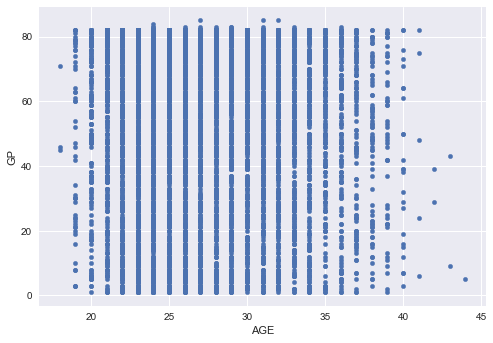

In [47]:
comb_df.plot(kind = 'scatter', x = 'AGE', y = 'GP')

In [106]:
player.get_player('Vince', 'Carter')

611    1713
Name: PERSON_ID, dtype: int64

In [111]:
player.PlayerShootingSplits(1713, season='1998-99').shot_areas()

,GROUP_SET,GROUP_VALUE,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,EFG_PCT,BLKA,...,EFG_PCT_RANK,BLKA_RANK,PCT_AST_2PM_RANK,PCT_UAST_2PM_RANK,PCT_AST_3PM_RANK,PCT_UAST_3PM_RANK,PCT_AST_FGM_RANK,PCT_UAST_FGM_RANK,CFID,CFPARAMS
0,Shot Area,Restricted Area,138,231,0.597,0,0,0.000,0.597,23,...,2,7,2,2,4,3,4,3,49,Restricted Area
1,Shot Area,In The Paint (Non-RA),63,135,0.467,0,0,0.000,0.467,8,...,3,5,3,1,4,3,6,1,49,In The Paint (Non-RA)
2,Shot Area,Mid-Range,125,334,0.374,0,0,0.000,0.374,9,...,6,6,1,3,4,3,3,4,49,Mid-Range
3,Shot Area,Left Corner 3,2,7,0.286,2,7,0.286,0.429,0,...,5,1,4,4,3,1,5,2,49,Left Corner 3
4,Shot Area,Right Corner 3,1,2,0.500,1,2,0.500,0.750,0,...,1,1,4,4,1,3,1,6,49,Right Corner 3
5,Shot Area,Above the Break 3,16,55,0.291,16,55,0.291,0.436,0,...,4,1,4,4,2,2,2,5,49,Above the Break 3
6,Shot Area,Backcourt,0,2,0.000,0,2,0.000,0.000,0,...,7,1,4,4,4,3,7,6,49,Backcourt


In [ ]:
#1998-99 -> 2016-17
sa_years = ['1998-99','1999-00','2000-01','2001-02','2002-03','2003-04','2004-05','2005-06','2006-07',
           '2007-08','2008-09','2009-10','2010-11','2011-12','2012-13','2013-14','2014-15','2015-16','2016-17']
temp_list = ['RA_FGA','RA_FG_PCT','P_FGA','P_FG_PCT','MR_FGA','MR_FG_PCT','LC_FGA','LC_FG_PCT','RC_FGA','RC_FG_PCT',
            'ATB_FGA','ATB_FG_PCT','BC_FGA','BC_FG_PCT']
for year in sa_years:
    cur_df = comb_df[comb_df['GROUP_VALUE'] == year]
    for pid in cur_df['PERSON_ID'].unique():
        pss = player.PlayerShootingSplits(pid, season=year).shot_areas()
        cur_list = []
        for i in range(7)
            cur_list.append(pss.iloc[i][3])
            cur_list.append(pss.iloc[i][4])
        temp_list.append(cur_list)

In [113]:
a = player.PlayerShootingSplits(1713, season='1998-99').shot_areas()

In [115]:
a.iloc[6][4]

0.0

In [117]:
for i in range(7):
    print (i)

0
1
2
3
4
5
6


In [112]:
comb_df.head()

,GROUP_VALUE,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,TOV,STL,...,PERSON_ID,SC_FG_PCT_DIFF,SC_FG3_PCT_DIFF,PO_FT_PCT_DIFF,4Q_FT_PCT_DIFF,SEASON_ID,GP,GS,AVG_MIN,AGE
0,1996-97,0.445,0.382,0.846,0.2,1.4,1.6,2.5,1.6,0.7,...,51,NaN,NaN,NaN,0.059,1996-97,75,51.0,28.4,28.0
1,1997-98,0.377,0.161,1.000,0.2,1.0,1.2,1.9,0.6,0.5,...,51,NaN,NaN,NaN,0.000,1997-98,31,0.0,17.1,29.0
2,2000-01,0.488,0.286,0.759,0.1,0.5,0.6,1.9,0.6,0.2,...,51,NaN,NaN,NaN,-0.027,2000-01,41,0.0,11.8,32.0
3,1997-98,0.403,0.211,0.672,0.7,1.2,2.0,0.9,1.1,0.6,...,1505,NaN,NaN,NaN,-0.018,1997-98,59,16.0,16.3,23.0
4,1998-99,0.435,0.286,0.691,1.5,2.3,3.8,1.0,1.4,1.0,...,1505,NaN,NaN,-0.122,0.491,1998-99,49,49.0,24.6,24.0


In [54]:
player.PlayerPerformanceSplits(200768).points_scored()

,GROUP_SET,GROUP_VALUE_ORDER,GROUP_VALUE,GROUP_VALUE_2,GP,W,L,W_PCT,MIN,FGM,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
0,Points Scored,0,W,All,36,36,0,1.0,36.7,7.2,...,1,2,2,2,2,1,1,1,51,None
1,Points Scored,5,W,90-99 Points,5,5,0,1.0,35.1,5.8,...,1,1,4,5,5,2,4,2,54,None
2,Points Scored,6,W,100+ Points,31,31,0,1.0,36.9,7.4,...,3,5,6,4,3,1,1,1,55,None
3,Points Scored,0,L,All,24,0,24,0.0,38.5,7.0,...,2,1,1,1,1,2,2,2,56,None
4,Points Scored,3,L,70-79 Points,1,0,1,0.0,34.4,7.0,...,6,6,5,6,2,6,4,2,57,None
5,Points Scored,4,L,80-89 Points,2,0,2,0.0,34.5,3.5,...,5,4,1,2,6,5,4,2,58,None
6,Points Scored,5,L,90-99 Points,7,0,7,0.0,38.9,6.9,...,2,3,2,3,4,4,3,2,59,None
7,Points Scored,6,L,100+ Points,14,0,14,0.0,39.2,7.5,...,4,2,3,1,1,3,2,2,60,None


Get Shot tracking for players: Touch time, shot distance, closest defender

In [73]:
player.PlayerInGameSplits(200768, season='2015-16').by_actual_margin()

,GROUP_SET,GROUP_VALUE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
0,By Actual Margin,Behind more than 20 Points,6,0,6,0.000,1.5,0.0,0.7,0.000,...,10,11,11,7,11,5,10,8,23,Behind more than 20 Points
1,By Actual Margin,Behind 16 - 20 Points,12,3,9,0.250,3.2,0.5,1.3,0.375,...,4,8,5,5,7,3,10,8,23,Behind 16 - 20 Points
2,By Actual Margin,Behind 11 - 15 Points,28,11,17,0.393,4.4,0.9,2.3,0.397,...,6,5,7,4,6,4,9,8,23,Behind 11 - 15 Points
3,By Actual Margin,Behind 6 - 10 Points,57,34,23,0.596,5.6,1.3,3.2,0.399,...,7,1,6,6,4,1,6,8,23,Behind 6 - 10 Points
4,By Actual Margin,Behind 1 - 5 Points,70,48,22,0.686,9.1,1.7,3.8,0.452,...,2,4,1,2,1,2,3,1,23,Behind 1 - 5 Points
5,By Actual Margin,Tied,77,54,23,0.701,2.6,0.4,1.1,0.415,...,8,9,10,11,9,7,1,1,23,Tied
6,By Actual Margin,Ahead 1 - 5 Points,75,54,21,0.720,8.6,1.6,3.4,0.461,...,5,3,2,3,2,6,1,1,23,Ahead 1 - 5 Points
7,By Actual Margin,Ahead 6 - 10 Points,60,50,10,0.833,8.4,1.4,3.3,0.434,...,1,2,3,1,3,8,4,1,23,Ahead 6 - 10 Points
8,By Actual Margin,Ahead 11 - 15 Points,47,42,5,0.894,5.8,0.9,2.1,0.412,...,3,6,4,8,5,10,5,1,23,Ahead 11 - 15 Points
9,By Actual Margin,Ahead 16 - 20 Points,26,23,3,0.885,3.0,0.3,0.9,0.304,...,11,10,8,9,10,11,7,1,23,Ahead 16 - 20 Points


In [84]:
player.PlayerClutchSplits(200768, season = '2007-08').last10sec_deficit_3point()

,GROUP_SET,GROUP_VALUE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,DD2_RANK,TD3_RANK,CFID,CFPARAMS
0,Last 10 SEC <= 3 PTS,2007-08,12,1,11,0.083,0.2,0.0,0.2,0.0,...,1,1,1,1,1,1,1,1,13,2007-08


Shot areas
Shot types
Shot splits (Decision making - more shots on higher prob?)
Clutch splits from 2007 - 2017,
